In [1]:

import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

current_dir = os.getcwd()
information_metrics_dir = os.path.dirname(current_dir)
sys.path.append(information_metrics_dir)

import src.utils.helper_functions as helper
import src.utils.normalizing_functions as norm
import src.wrappers.spatial_metrics_calcium_binarized_base as sm
import src.utils.bootstrapped_estimation as bootstrap

from src.data.data_loader import LoadData
from src.data.data_processing import ProcessData
from src.utils import pre_processing_functions as pre_process
import src.data.cell_model_base as cs_model

%matplotlib widget


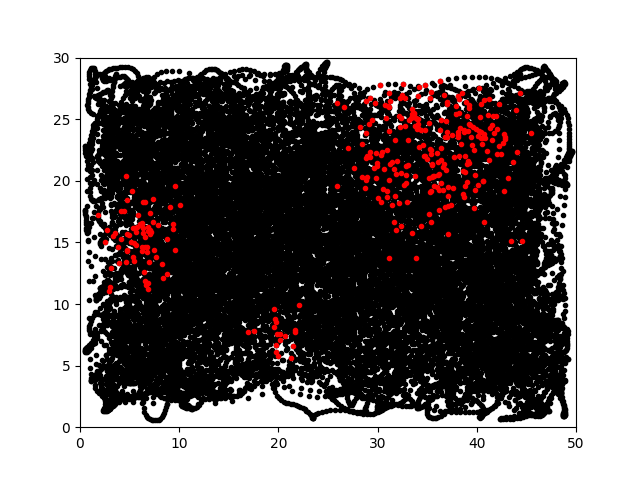

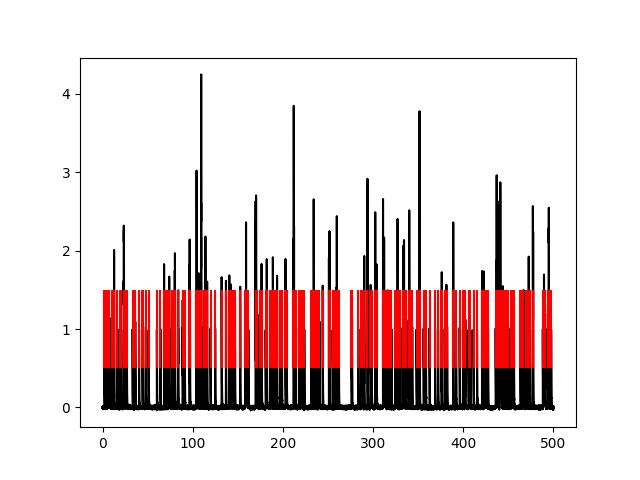

In [2]:

# Cell simulation parameters
sampling_rate = 50. # points/frames per second
duration = 500 # in seconds
rate = 10 # how much your neuron should spike
environment_edges = [[0,50],[0,30]] # in cm [[x_min,x_max],[y_min,y_max]]
smooth_time = 0.1
rho1 = 0.02
sigma = 1
mu_e = 0.

# Define field parameters
num_of_fields = 3

field1_center = (5, 15)
field2_center = (20, 7)
field3_center = (35, 25)
field1_size = 2
field2_size = 1
field3_size = 4

x_coordinates,y_coordinates,speed,speed_smoothed,time_vector = cs_model.generate_random_walk(input_srate = sampling_rate,input_total_Time = duration,heading_srate = 10., speed_srate = 5., rho1  = rho1,sigma = sigma,mu_e  = mu_e, smooth_points = int(np.round(smooth_time*sampling_rate)),environment_edges = environment_edges)
total_points = time_vector.shape[0]

spike_times = cs_model.generate_poisson_spikes(rate, duration)
spike_times_idx = (spike_times*sampling_rate).astype(int)

if num_of_fields == 0:
    modulated_spike_times_idx = spike_times_idx.copy()
else:
    modulated_spike_times_idx = []
    for counter in range(num_of_fields):
        field_center = eval('field' + str(counter+1) + '_center')
        field_size = eval('field' + str(counter+1) + '_size')
        modulated_spike_times_idx_aux = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,spike_times_idx,x_center = field_center[0],y_center = field_center[1], s = field_size)
    
        modulated_spike_times_idx.append(modulated_spike_times_idx_aux)
    modulated_spike_times_idx = np.unique(np.concatenate(modulated_spike_times_idx)).astype(int)
    
signal,time_vector = cs_model.generate_calcium_signal(modulated_spike_times_idx,total_points,sampling_rate,noise_level = 0.01, b = 5.)
peaks_idx = helper.detect_peaks(signal,mpd=0.5*sampling_rate,mph=1.*np.nanstd(signal))


plt.close('all')
plt.figure()
plt.plot(x_coordinates, y_coordinates,'k.')
if len(modulated_spike_times_idx) > 0:
    plt.plot(x_coordinates[modulated_spike_times_idx],y_coordinates[modulated_spike_times_idx],color = 'red',linestyle='',marker='.',markersize=6)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
# plt.gca().set_aspect('equal', 'box')
plt.show()

plt.figure()
plt.plot(time_vector, signal,'k')
if len(modulated_spike_times_idx) > 0:
    plt.eventplot(time_vector[modulated_spike_times_idx],color='red')
plt.show()


In [3]:

signal_type = 'binary'
normalized_signal = norm.z_score_norm(signal)
binary_signal = pre_process.preprocess_signal(normalized_signal, sampling_rate, signal_type, z_threshold = 1)


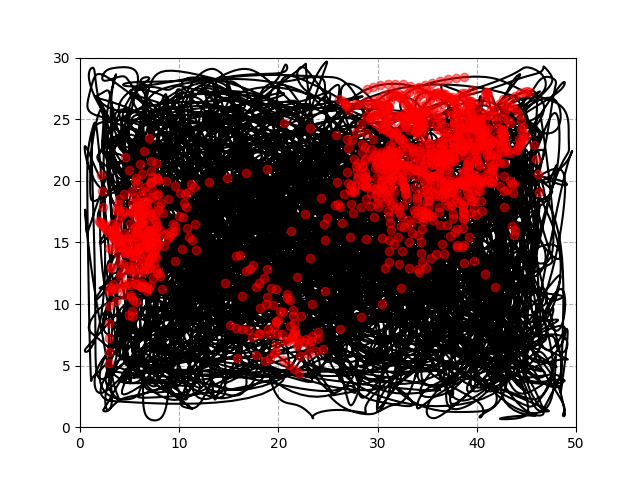

In [4]:
# And test it

plt.figure()
plt.plot(x_coordinates,y_coordinates,'k',zorder = 5)
plt.scatter(x_coordinates[binary_signal==1],y_coordinates[binary_signal==1],color = 'red', alpha=0.5, zorder = 10)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.grid(ls='--',zorder = 1)
plt.show()


In [9]:
# These parameters were taken from the paper 
# "Hippocampal Place Fields Maintain a Coherent and Flexible Map across Long Timescales"

# Create a dictionary to hold input parameters for further processing
input_dict = {

# Construct the filename and other identifiers for saving the results
'saving_string' : 'SpatialMetrics.' + signal_type,  # Prefix for the filename
'animal_id' : 'NeuronModel',  # Identifier for the animal or model
'dataset' : 'Simulation',  # Name of the dataset
'day' : 1,  # Day or session number
'neuron' : 1,  # Neuron identifier
'trial' : None,  # Trial identifier (optional, can be None)
'saving_path' : None,  # Directory path for saving results (optional, can be None)
'saving' : False,  # Flag indicating whether to save the results (False means no saving)
'overwrite': False, # Flag indicating whether to overwrite already saved file 
'signal_type' : signal_type, # 'binary' or 'continuous'

# Set inclusion criteria for the analysis
# Kinky used 50 ms minimum occupancy 
'min_time_spent' : 0,  # Minimum time an animal must spend in each xy bin in time_vector units (usually, in seconds)
'min_visits' : 0,  # Minimum number of visits required in each xy bin
'min_speed_threshold' : 0,  # Minimum speed threshold (in coordinate units [e.g., cm, pixels])
'speed_smoothing_sigma' : 0.5,  # Std of the gaussian smooth. Units is the same as time vector (seconds, for instance)

# Set parameters for plotting and information score from map
'x_bin_size' : 1,  # Size of x bins (in coordinate units [e.g., cm, pixels])
'y_bin_size' : 1,  # Size of y bins (in coordinate units [e.g., cm, pixels])
'map_smoothing_sigma_x' : 2.5,  # Size of the gaussian smoothing area (std in coordinate units [e.g., cm, pixels]) for plotting activity maps
'map_smoothing_sigma_y' : 2.5, # Size of the gaussian smoothing area (std in coordinate units [e.g., cm, pixels]) for plotting activity maps

# Set parameters for information calculation
'x_bin_size_info' : 4,  # Size of x bins (in coordinate units [e.g., cm, pixels])
'y_bin_size_info' : 4,  # Size of y bins (in coordinate units [e.g., cm, pixels])

# Set parameters for surrogate analysis
'shift_time' : 20,  # Time shift window in seconds for creating surrogate distributions
'num_cores' : -1,  # Number of CPU cores to use (set to -1 to use all available cores)
'num_surrogates' : 800,  # Number of surrogate distributions to generate

# Set parameters for place fields detection
'min_num_of_bins' : 1,  # Minimum number of spatial bins required to define a place field
'threshold': ('percentile',50),

# Set parameters for place fields extension
'threshold_fraction': 0.5, # fraction of the peak activity within each field to define the place field extension

'alpha' : 0.05 # alpha on the decision if a cell can be classified as a place cell 

}

signal_data = ProcessData(binary_signal, x_coordinates, y_coordinates, time_vector, sampling_rate, environment_edges)

spatial_metrics = sm.PlaceCellBinarized(**input_dict)
spatial_metrics_output = spatial_metrics.main(signal_data)


Processing Surrogates:   0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

SpatialMetrics.binary.NeuronModel.Dataset.Simulation.Day.1.Neuron.1 not saved


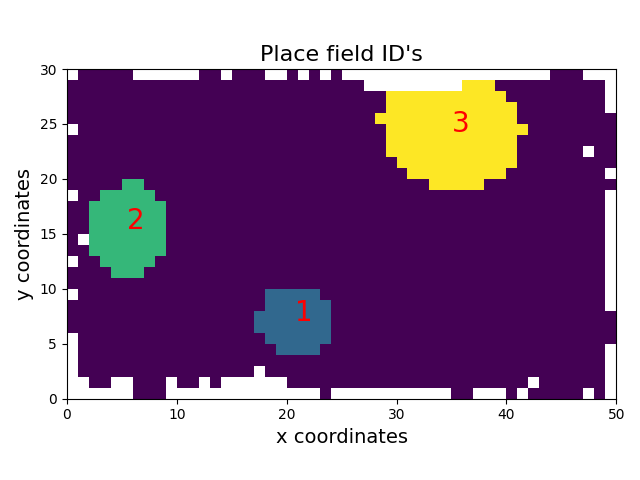

In [8]:

place_cells_x_center_coord = spatial_metrics_output['fields_x_max']
place_cells_y_center_coord = spatial_metrics_output['fields_y_max']

plt.figure()
plt.pcolormesh(spatial_metrics_output['x_center_bins'],spatial_metrics_output['y_center_bins'],spatial_metrics_output['activity_map_identity'])
if spatial_metrics_output['num_of_fields'] > 0:
    for x, y,field_id in zip(place_cells_x_center_coord, place_cells_y_center_coord, spatial_metrics_output['field_ids']):
        plt.text(x, y, str(field_id), color='red',fontsize=20)

plt.title("Place field ID's",fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([signal_data.environment_edges[0][0],signal_data.environment_edges[0][1]])
plt.ylim([signal_data.environment_edges[1][0],signal_data.environment_edges[1][1]])
plt.gca().set_aspect('equal')  # optional: equal aspect ratio for x/y

plt.tight_layout()
plt.show()


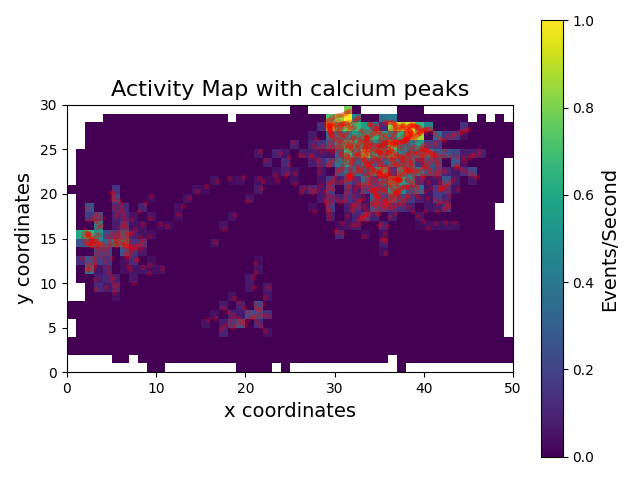

In [21]:

plt.figure()
plt.pcolormesh(spatial_metrics_output['x_grid'],spatial_metrics_output['y_grid'],spatial_metrics_output['activity_map'],edgecolors=None)
colorbar = plt.colorbar()
colorbar.set_label('Events/Second',fontsize=14)

plt.plot(spatial_metrics_output['peaks_x_location'],spatial_metrics_output['peaks_y_location'],color = 'red',linestyle='',marker='.',markersize=6,alpha=0.2)

plt.title('Activity Map with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([signal_data.environment_edges[0][0],signal_data.environment_edges[0][1]])
plt.ylim([signal_data.environment_edges[1][0],signal_data.environment_edges[1][1]])
plt.gca().set_aspect('equal')  # optional: equal aspect ratio for x/y
plt.tight_layout()
plt.show()


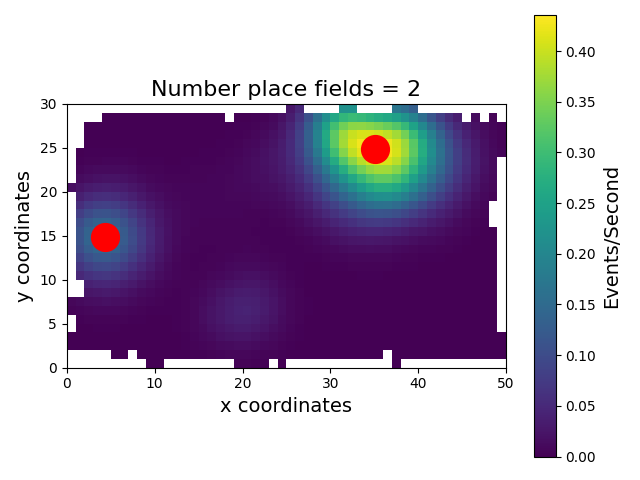

In [22]:
place_cells_x_center_coord = spatial_metrics_output['fields_x_max']
place_cells_y_center_coord = spatial_metrics_output['fields_y_max']

nan_mask = np.isnan(spatial_metrics_output['activity_map'])
activity_map_smoothed = spatial_metrics_output['activity_map_smoothed'].copy()
activity_map_smoothed[nan_mask] = np.nan

plt.figure()
plt.pcolormesh(spatial_metrics_output['x_center_bins'],spatial_metrics_output['y_center_bins'],activity_map_smoothed)
colorbar = plt.colorbar()
colorbar.set_label('Events/Second',fontsize=14)

plt.plot(place_cells_x_center_coord,place_cells_y_center_coord,'r.',markersize=40)

plt.title('Number place fields = {0}'.format(spatial_metrics_output['num_of_fields']) ,fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([signal_data.environment_edges[0][0],signal_data.environment_edges[0][1]])
plt.ylim([signal_data.environment_edges[1][0],signal_data.environment_edges[1][1]])
plt.gca().set_aspect('equal')  # optional: equal aspect ratio for x/y

plt.tight_layout()
plt.show()


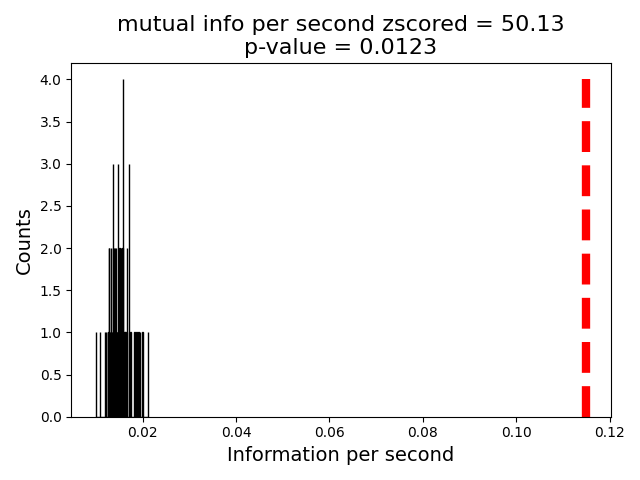

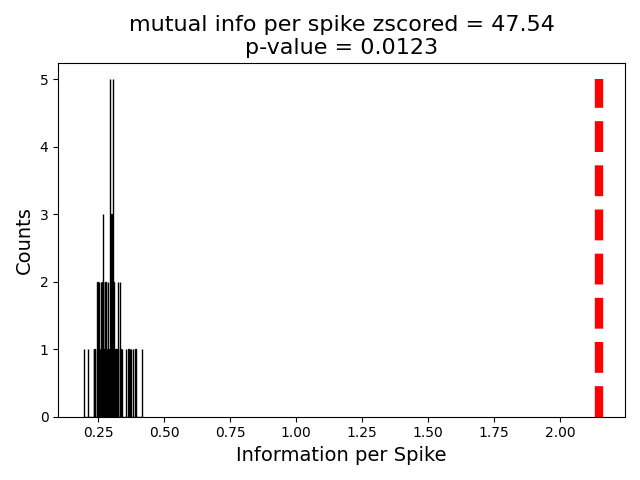

In [23]:

p_value = spatial_metrics_output['mutual_info_per_second_pvalue']
counts,bins = np.histogram(spatial_metrics_output['mutual_info_per_second_shifted'],200)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([spatial_metrics_output['mutual_info_per_second_original'],spatial_metrics_output['mutual_info_per_second_original']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("mutual info per second zscored = {0:.2f}\np-value = {1:.4f}".format(spatial_metrics_output['mutual_info_per_second_zscored'],p_value),fontsize=16)
plt.xlabel('Information per second',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()



p_value = spatial_metrics_output['mutual_info_per_spike_pvalue']
counts,bins = np.histogram(spatial_metrics_output['mutual_info_per_spike_shifted'],200)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([spatial_metrics_output['mutual_info_per_spike_original'],spatial_metrics_output['mutual_info_per_spike_original']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("mutual info per spike zscored = {0:.2f}\np-value = {1:.4f}".format(spatial_metrics_output['mutual_info_per_spike_zscored'],p_value),fontsize=16)
plt.xlabel('Information per Spike',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()


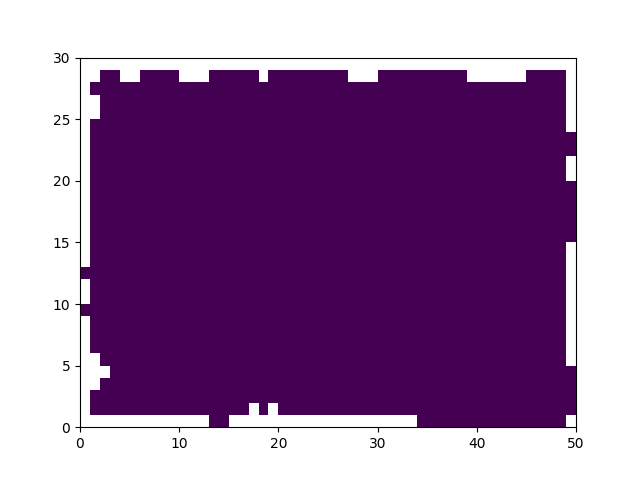

In [70]:

refined_identity = np.full_like(activity_map_identity, 0)  # default to sea
refined_identity[np.isnan(activity_map_identity)] = np.nan  # preserve ignored
refined_identity

plt.figure()
plt.pcolormesh(refined_identity)
plt.show()


In [71]:

field_ids = np.unique(activity_map_identity[~np.isnan(activity_map_identity)])
field_ids = field_ids[field_ids > 0]  # skip 0 and NaNs
field_ids

array([1., 2., 3.])

In [72]:
field_id = 1

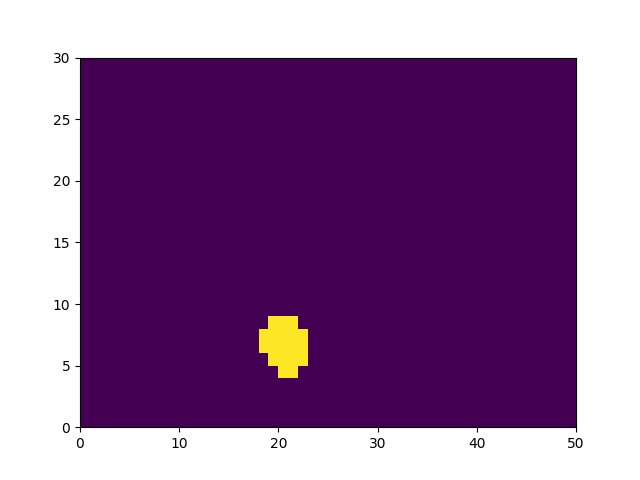

In [74]:

# Create mask of this island
field_mask = activity_map_identity == field_id


plt.figure()
plt.pcolormesh(field_mask)
plt.show()

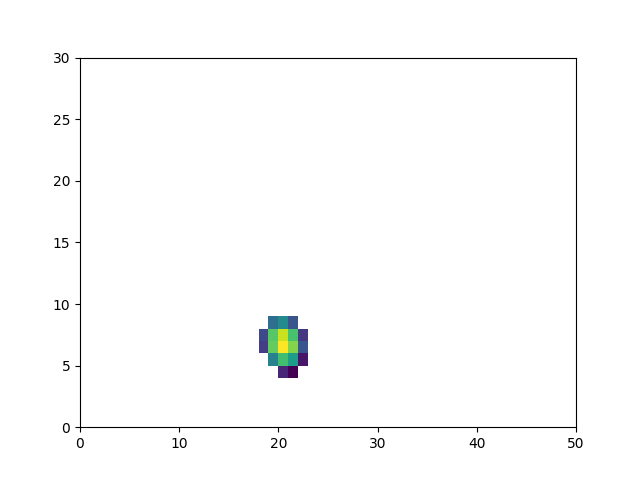

In [77]:

# Get activity inside the island
field_activity = np.where(field_mask, activity_map, np.nan)
field_activity

plt.figure()
plt.pcolormesh(field_activity)
plt.show()

In [84]:
threshold_fraction = 0.5
# Find peak
peak_idx = np.nanargmax(field_activity)
peak_coords = np.unravel_index(peak_idx, activity_map.shape)
peak_value = activity_map[peak_coords]
threshold = threshold_fraction * peak_value


In [65]:

    # Flood fill from peak, keeping only 8-connected bins that:
    # - belong to the island
    # - pass the threshold
    visited = set()
    to_visit = [peak_coords]

    while to_visit:
        x, y = to_visit.pop()
        if (x, y) in visited:
            continue
        visited.add((x, y))

        if not field_mask[x, y]:
            continue
        if activity_map[x, y] < threshold:
            continue

        refined_identity[x, y] = field_id

        # 8-connectivity
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                nx, ny = x + dx, y + dy
                if 0 <= nx < activity_map.shape[0] and 0 <= ny < activity_map.shape[1]:
                    if (nx, ny) not in visited:
                        # Only consider if belongs to same island and passes threshold
                        if field_mask[nx, ny] and activity_map[nx, ny] >= threshold:
                            to_visit.append((nx, ny))



In [86]:
import numpy as np

def refine_place_fields_by_peak_connectivity(activity_map, activity_map_identity, field_ids, threshold_fraction=0.5):
    """
    Keeps only bins within each island that are:
    - Connected to the peak bin (8-connected in 2D, adjacent in 1D)
    - Above threshold_fraction * peak value
    - In the original island (id > 0)

    Parameters
    ----------
    activity_map : np.ndarray
        The smoothed activity map. Can be 1D or 2D.
    activity_map_identity : np.ndarray
        Array with labeled islands. Use:
            - NaN for ignored bins
            - 0 for background ("sea")
            - positive ints (1, 2, 3, ...) for valid islands
    threshold_fraction : float
        Fraction of peak activity to include (e.g., 0.5 = 50%)

    Returns
    -------
    refined_identity : np.ndarray
        Same shape, with cleaned island maps (same IDs, no relabeling).
    """
    refined_identity = np.full_like(activity_map_identity, 0)
    refined_identity[np.isnan(activity_map_identity)] = np.nan

    is_1d = activity_map.ndim == 1

    for field_id in field_ids:
        field_mask = activity_map_identity == field_id
        field_activity = np.where(field_mask, activity_map, np.nan)

        peak_idx_flat = np.nanargmax(field_activity)
        peak_value = activity_map.flat[peak_idx_flat]
        threshold = threshold_fraction * peak_value

        visited = set()

        if is_1d:
            to_visit = [peak_idx_flat]
            while to_visit:
                i = to_visit.pop()
                if i in visited:
                    continue
                visited.add(i)

                if not field_mask[i] or activity_map[i] < threshold:
                    continue

                refined_identity[i] = field_id

                for ni in [i - 1, i + 1]:
                    if 0 <= ni < activity_map.shape[0] and ni not in visited:
                        if field_mask[ni] and activity_map[ni] >= threshold:
                            to_visit.append(ni)

        else:
            peak_coords = np.unravel_index(peak_idx_flat, activity_map.shape)
            to_visit = [peak_coords]

            while to_visit:
                x, y = to_visit.pop()
                if (x, y) in visited:
                    continue
                visited.add((x, y))

                if not field_mask[x, y] or activity_map[x, y] < threshold:
                    continue

                refined_identity[x, y] = field_id

                for dx in [-1, 0, 1]:
                    for dy in [-1, 0, 1]:
                        if dx == 0 and dy == 0:
                            continue
                        nx, ny = x + dx, y + dy
                        if 0 <= nx < activity_map.shape[0] and 0 <= ny < activity_map.shape[1]:
                            if (nx, ny) not in visited:
                                if field_mask[nx, ny] and activity_map[nx, ny] >= threshold:
                                    to_visit.append((nx, ny))

    return refined_identity


In [61]:
activity_map_identity_2 = activity_map_identity.copy()
activity_map_identity_2[np.isnan(activity_map_identity_2)] = 0

In [88]:
refined_identity = refine_place_fields_by_peak_connectivity(activity_map, activity_map_identity, field_ids, threshold_fraction=0.5)


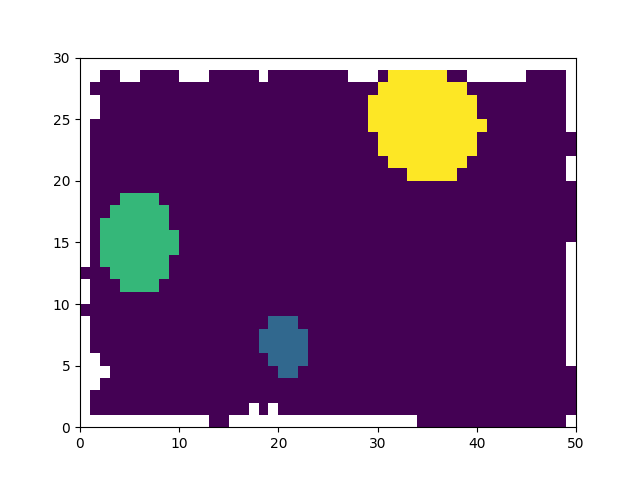

In [90]:

plt.figure()
plt.pcolormesh(refined_identity)
plt.show()

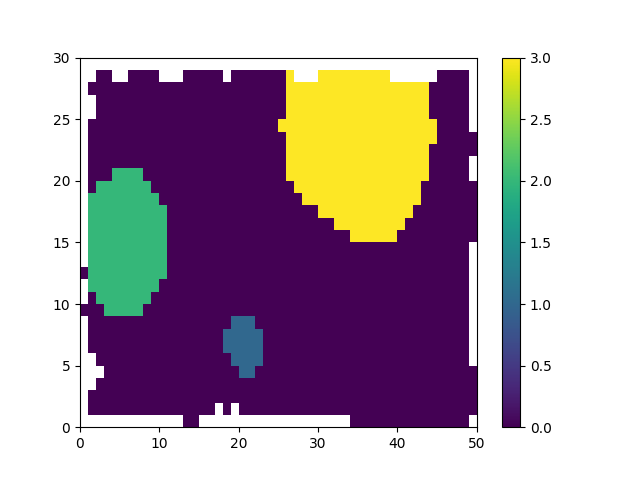

In [52]:

plt.figure()
plt.pcolormesh(activity_map_identity)
plt.colorbar()
plt.show()


In [22]:
field_mask = (activity_map_identity == fid)
field_values = activity_map[field_mask]
peak_value = np.nanmax(field_values)
peak_value

np.float64(0.45441219634225877)

In [24]:
threshold_ratio = 0.5
threshold = threshold_ratio * peak_value
above_thresh_mask = (activity_map >= threshold) & field_mask
above_thresh_mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(30, 50))

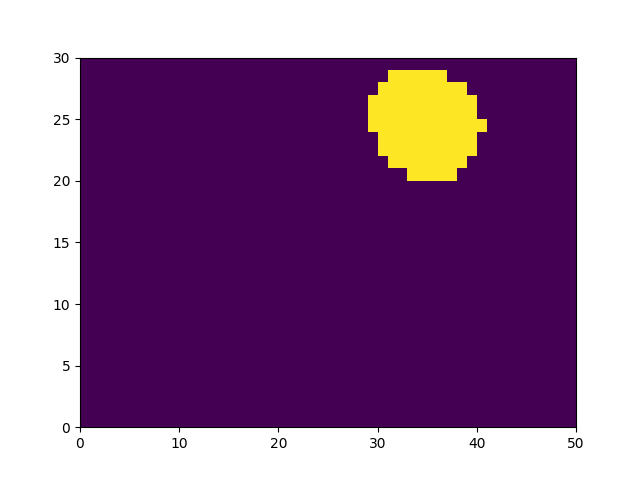

In [25]:
plt.figure()
plt.pcolormesh(above_thresh_mask)
plt.show()

In [45]:
np.unique(labeled_field)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32)

In [43]:
labeled_field

array([[1, 1, 1, ..., 0, 0, 3],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [6, 0, 0, ..., 0, 0, 6],
       [6, 6, 0, ..., 0, 0, 6],
       [6, 6, 6, ..., 6, 6, 6]], shape=(30, 50), dtype=int32)

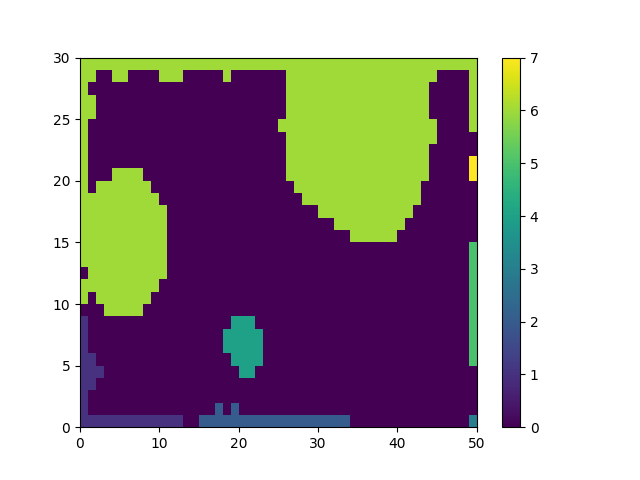

In [46]:

# label contiguous parts
labeled_field, num = label(activity_map_identity.astype(int), structure=np.ones((3, 3)) if activity_map.ndim == 2 else [1, 1, 1])

plt.figure()
plt.pcolormesh(labeled_field)
plt.colorbar()
plt.show()

In [ ]:

# label contiguous parts
labeled_field, num = label(above_thresh_mask.astype(int), structure=np.ones((3, 3)) if activity_map.ndim == 2 else [1, 1, 1])

plt.figure()
plt.pcolormesh(labeled_field)
plt.colorbar()
plt.show()

In [ ]:



    for island_idx in range(1, num + 1):
        this_island = (labeled_field == island_idx)
        if np.nansum(this_island) >= min_num_of_bins:
            refined_map[this_island] = new_id
            new_id += 1

In [14]:
activity_map = spatial_metrics_output['activity_map_smoothed'].copy()
activity_map_identity = spatial_metrics_output['activity_map_identity'].copy()
fields_id = spatial_metrics_output['fields_id'].copy()



In [15]:
refined_map = refine_place_fields_by_peak_threshold(activity_map, activity_map_identity, fields_id, threshold_ratio=0.5, min_num_of_bins=2)

NameError: name 'refined_map' is not defined

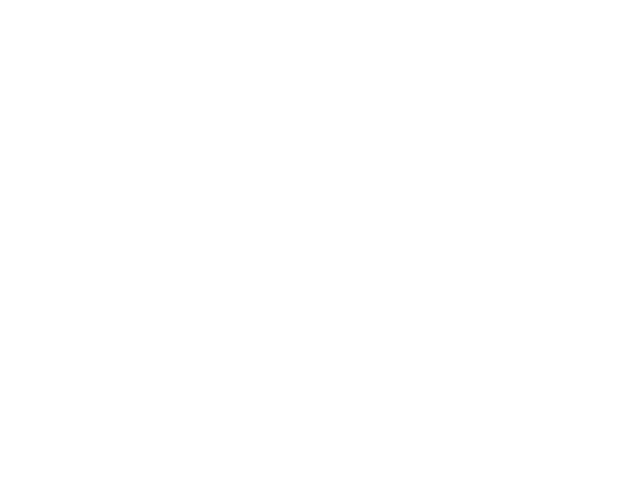

In [8]:

place_cells_x_center_coord = spatial_metrics_output['fields_x_max']
place_cells_y_center_coord = spatial_metrics_output['fields_y_max']

plt.figure()
plt.pcolormesh(spatial_metrics_output['x_center_bins'],spatial_metrics_output['y_center_bins'],refined_map)
if spatial_metrics_output['num_of_fields'] > 0:
    for x, y,field_id in zip(place_cells_x_center_coord, place_cells_y_center_coord, spatial_metrics_output['fields_id']):
        plt.text(x, y, str(field_id), color='red',fontsize=20)

plt.title("Place field ID's",fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([signal_data.environment_edges[0][0],signal_data.environment_edges[0][1]])
plt.ylim([signal_data.environment_edges[1][0],signal_data.environment_edges[1][1]])
plt.gca().set_aspect('equal')  # optional: equal aspect ratio for x/y

plt.tight_layout()
plt.show()


In [44]:
# Place field extension: % relative to the whole enviroment
spatial_metrics_output['place_cell_extension_absolute']


array([0.06133333, 0.05933333, 0.15333333])

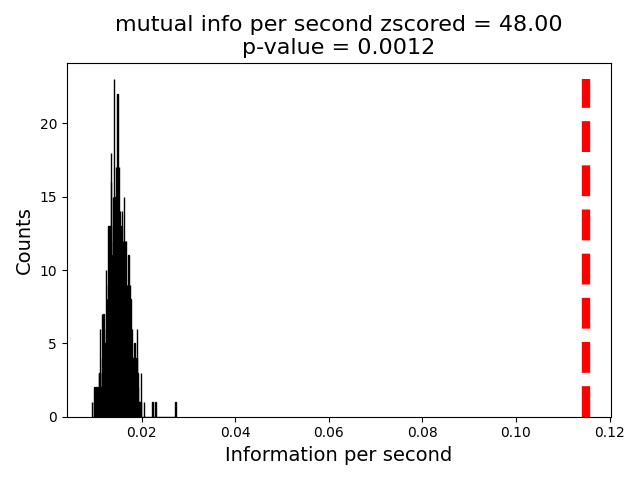

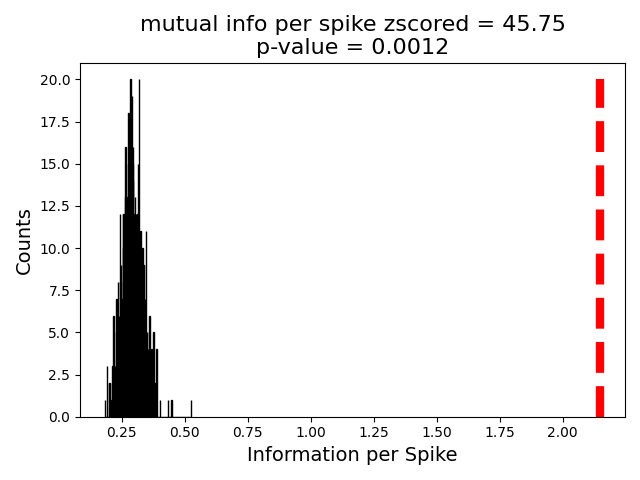